In [1]:
import argparse
import json
import os
from animus.torch.engine import CPUEngine, DDPEngine, DPEngine, GPUEngine, XLAEngine
from neurone.utils.general import load_yaml
import torch
import datetime 
from datetime import datetime 
import numpy as np

# Runners
from neurone.runners.detection import BaseDetectionRunner, HeatmapDetectionRunner
from neurone.runners.segmentation import BaseSegmentationRunner
#from neurone.runners.extended import HeatmapExtendedDetectionRunner
from neurone.runners.gridsearch import GridSearchRunner

E2E = {
    "cpu": CPUEngine,
    "gpu": GPUEngine,
    "dp": DPEngine,
    "ddp": DDPEngine,
    "xla": XLAEngine,
}

#args.engine = "cpu"
#args.tracker = "tensorboard"

print('Get current working directory : ', os.getcwd())
config_path = "./configs/detection.json"
!cat ./configs/detection.json
with open(config_path, "r") as config_file:
        config = json.load(config_file)
        
        
config["data"]["split_info"] = "/home/data-histology/endonuke_data/trainval/split_info.yml"
config["train"]["experiment_name"] = config["train"]["save_dir"] + " " + config["train"]["experiment_name"]  + " " + str(datetime.now())
#whether to overwrite the model or not
#config["train"]["verbose"] = True
#config["train"]["overwrite"] = True
config["train"]["deterministic"] = False
config["train"]["seed"] = 42
config["train"]["checkpoints_dir"] = "checkpoints"
config["train"]["logging_dir"] = "logs"
config['train']['tracker'] = "tensorboard"
config["train"]["engine"] = "cpu"
if config["train"]["deterministic"]:
    torch.use_deterministic_algorithms(config["train"]["deterministic"])
logging_dir = os.path.join(config["train"]["save_dir"], config["train"]["experiment_name"])
    
runner = globals()[config["model"]["runner"]](engine=E2E["cpu"](
    log_with="tensorboard", logging_dir=logging_dir), config=config)
        

Get current working directory :  /home/alexmak123/neurone
{
  "model": {
    "runner": "HeatmapDetectionRunner",
    "model_name": "HeatmapDetector",
    "model_kwargs": {
      "backbone": "Unet",
      "encoder_name": "resnet34",
      "encoder_depth": 5,
      "encoder_weights": "imagenet",
      "in_channels": 3,
      "classes": 2,
      "activation": null,
      "min_peak_value": 0.245,
      "pooling_scale": 7,
      "out_image_shape": [
        512,
        512
      ],
      "supression_range": 3.099
    },
    "weigths_path": "/home/alexmak123/neurone/experiments/experiment_2022-10-27 19:25:38.336325/model.pth",
    "class_separator": null,
    "class_labels_map": {
      "0": 0,
      "1": 1,
      "2": 0
    },
    "input_shape": [
      512,
      512
    ]
  },
  "data": {
    "split_info": null,
    "dataset_dir": "/home/data-histology/endonuke_data/trainval",
    "save_console_logs": true,
    "workers": 2,
    "heatmaps_sigma": 7.62,
    "norm_mean": [
      213,
     

In [2]:
# Specify Model
runner._setup_model()
runner.model.eval()

HeatmapDetector(
  (heatmap_model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

/home/alexmak123/test_train_tile
'test_tile2.jpg?raw=true'  'test_tile3.jpg?raw=true'  'test_tile.jpg?raw=true'
Get current working directory :  /home/alexmak123/test_train_tile
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(3, 512, 512, 3)


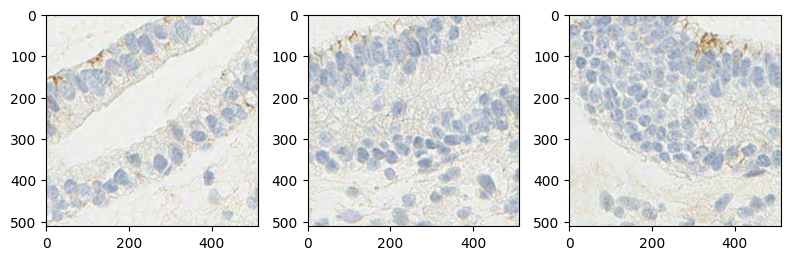

In [3]:
#some transformations for propper data fromat
import matplotlib.pyplot as plt
import albumentations as A
%matplotlib inline
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
alb_transforms = A.Compose([A.augmentations.Resize(512, 512)])

#Download our tile
%cd ../test_train_tile
%ls 
print('Get current working directory : ', os.getcwd())
directory_in_str = "/home/alexmak123/test_train_tile"

import cv2
from PIL import Image

def import_tiles_from_directory_and_convert_them (directory_in_str):
    directory = os.fsencode(directory_in_str)
    converted_images = []
    i = 1
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith("?raw=true"): 
            myTile = np.array(Image.open(filename).convert('RGB'))
            myTile = alb_transforms(image=myTile)["image"]
            print (myTile.shape)
            plt.subplot(3, 3, i)
            plt.imshow(myTile)
            converted_images.append(myTile)
            i += 1
            continue
        else:
            continue
    return np.array(converted_images)

converted_images = import_tiles_from_directory_and_convert_them (directory_in_str)
print (converted_images.shape)
#print (converted_images)

In [4]:
import sys


#our data to tensor
image_torch = torch.tensor(converted_images)
print (image_torch.shape)

#image_torch = torch.unsqueeze(image_torch, 0)
image_torch = image_torch.permute(0, 3, 1, 2) 
image_torch = image_torch.float()

#here should be meanstd values, counted for this picture, but with counted meanstd it doesn't classify properly on stroma and epithelium. That's why we use standard meanstd values

#!!!NOTE: ASK ABOUT THIS!!!
#config["data"]["norm_mean"][0], config["data"]["norm_mean"][1], config["data"]["norm_mean"][2] = (170, 154, 144)
#config["data"]["norm_std"][0], config["data"]["norm_std"][1], config["data"]["norm_std"][2] = (63, 69, 71)
image_torch -= torch.tensor([config["data"]["norm_mean"][0], config["data"]["norm_mean"][1], config["data"]["norm_mean"][2]]).reshape(-1, 1, 1)
image_torch /= torch.tensor([config["data"]["norm_std"][0], config["data"]["norm_std"][1], config["data"]["norm_std"][2]]).reshape(-1, 1, 1)
    

#np.set_printoptions(threshold=sys.maxsize)
print ("Keypoints of all tiles : \n")
keypoints = runner.model(image_torch)["keypoints"]
print (keypoints, "\n")
print ("Confidences of all tiles : \n")
confidences = runner.model(image_torch)["confidences"]
print (confidences, "\n")

#x_coords = keypoints.x_coords()
#y_coords = keypoints.y_coords()
#classes = keypoints.classes()


torch.Size([3, 512, 512, 3])
Keypoints of all tiles : 

[[  0.  20. 222.   0.]
 [  0. 156. 418.   0.]
 [  0. 277.  49.   0.]
 ...
 [  2. 207. 188.   0.]
 [  2. 438. 358.   0.]
 [  2. 324. 196.   0.]] 

Confidences of all tiles : 

[0.01164998 0.01701014 0.03312309 0.05982941 0.07624279 0.09287201
 0.11617071 0.12189655 0.12295822 0.13138525 0.13457671 0.13623482
 0.1662233  0.1701062  0.17070079 0.1797577  0.1906145  0.19530287
 0.20834397 0.23183502 0.23315947 0.26629665 0.28165638 0.28844047
 0.32654324 0.33469176 0.3713517  0.3752121  0.38978508 0.39066416
 0.40595043 0.4178861  0.4432964  0.44759992 0.46123993 0.4653607
 0.4673046  0.47640824 0.48489767 0.48681325 0.49205986 0.49531
 0.5073022  0.5215261  0.5259103  0.5493689  0.55078346 0.6068139
 0.61542594 0.6219562  0.63563603 0.6381023  0.64426637 0.65324837
 0.66202474 0.6634601  0.6635538  0.67129475 0.7007002  0.70182407
 0.7067048  0.71184194 0.73965204 0.74327415 0.79033935 0.9388416
 0.01677752 0.03220139 0.04616644 0.05

In [5]:
#split keypoints of all tiles to array of selected colums with x_coords, y_coords and classes of all tiles
#later we would not need this, but for demonstration that everything works properly we will add these "tiles split"
j = 0
selected_columns_array = []
for index_tile in range(converted_images.shape[0]):
    selected_columns = []
    while (j < keypoints.shape[0] and keypoints[j][0] == index_tile):
        selected_columns.append([keypoints[j][1], keypoints[j][2], keypoints[j][3]])
        j += 1
    selected_columns_array.append(np.array(selected_columns))
    
print (np.array(selected_columns_array, dtype=object))

[array([[ 20., 222.,   0.],
        [156., 418.,   0.],
        [277.,  49.,   0.],
        [371., 294.,   0.],
        [393., 390.,   0.],
        [317., 283.,   0.],
        [209., 344.,   0.],
        [435., 234.,   0.],
        [ 16., 424.,   0.],
        [396., 252.,   0.],
        [247.,  78.,   0.],
        [ 22., 156.,   0.],
        [180., 388.,   0.],
        [364.,  13.,   0.],
        [317., 337.,   0.],
        [279., 362.,   0.],
        [450., 192.,   0.],
        [ 57., 405.,   0.],
        [ 58., 195.,   0.],
        [188., 403.,   0.],
        [ 10., 173.,   0.],
        [123., 448.,   0.],
        [403., 266.,   0.],
        [487., 218.,   0.],
        [293., 376.,   0.],
        [ 10., 284.,   0.],
        [211., 126.,   0.],
        [ 35., 457.,   0.],
        [125., 138.,   0.],
        [415., 282.,   0.],
        [439., 480.,   0.],
        [203.,  58.,   0.],
        [191., 106.,   0.],
        [141., 160.,   0.],
        [505., 146.,   0.],
        [ 29., 488.,

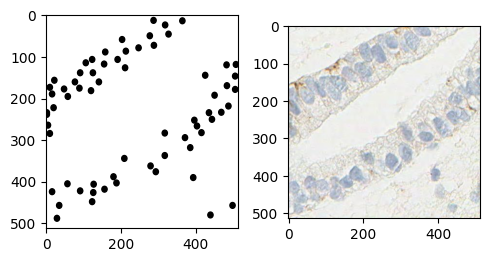

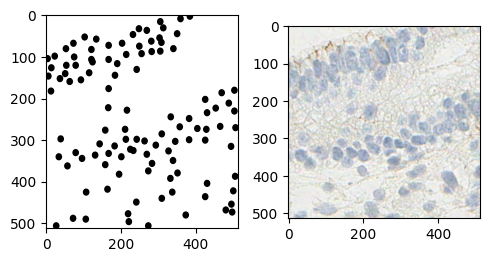

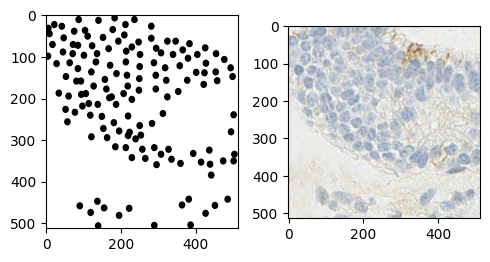

In [6]:
#make pictures
#Set the figure size
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True


for index_tile in range(converted_images.shape[0]):
    plt.subplot(2, 2, 1)
    #with circles
    ax = plt.gca()
    ax.cla()
    ax.set_xlim((0, 512))
    ax.set_ylim((0, 512))
    ax.invert_yaxis()
    circles_type={"radius": 7, "alpha": 1.0,  "linewidth": 1, 'ec': (0,0,0)}
    colormap = np.array(['k', 'b'])
    for dot_center in selected_columns_array[index_tile]:
        patch = plt.Circle((dot_center[0], dot_center[1]), color=colormap[dot_center[2].astype(int)], **circles_type)
        ax.add_patch(patch)


    plt.subplot(2, 2, 2)
    plt.imshow(converted_images[index_tile])
    plt.show()

In [7]:
#right now we will count the color of our stromas (cutting out the center) (stromas are on the left picture above and they are colored in black)
#note : first we get rgb colors and then we should convert them to hsv (to get rid of the Blue part, so that we can define brown)
#in this function we have selected_colums, which are our keypoints; cell_size which is a size of our sell; and cut_center_size which is a size of a square that we are cutting from our original cell
import math

def pixel_values_of_the_toruses(selected_columns, myTile, cell_size, cut_center_size = 0):
    if (cut_center_size > cell_size):
        raise ValueError("your cut_center_size is more than a cell_size")
    
    list_of_cells = []
    for dot_center in selected_columns:
        #we want only stromas
        if (dot_center[2] == 0): 
            x = dot_center[0].astype(int)
            y = dot_center[1].astype(int)
        
            #here we count max bounds of i and j for cell size and cut_center_size
        
            #!!!
            max_bound_for_cell = cell_size//2 
            max_bound_for_cut_center = cut_center_size//2
            #!!!
        
            i, j = -max_bound_for_cell, -max_bound_for_cell
            myCell = []
            #print ("new pair " + str(cell_size) + "x" + str(cell_size) + " : \n")
            while (x+i >= 0 and x+i < 512 and i <= max_bound_for_cell):
                j = -max_bound_for_cell
                while (y+j >= 0 and y+j < 512 and j <= max_bound_for_cell):
                    if (i >= -max_bound_for_cut_center and i <= max_bound_for_cut_center and j >= -max_bound_for_cut_center and j <= max_bound_for_cut_center):
                        j += 1
                        continue
                    #print(i, j)
                    #print(myTile[x+i][y+j])
                    myCell.append(myTile[x+i][y+j])
                    j += 1
                i += 1
                
            #print(np.array(myCell))
            if(cut_center_size == 0):
                myCell.append(myTile[x][y])
            if (len(myCell) != 0):
                list_of_cells.append(myCell)
            
    return np.array(list_of_cells, dtype = object)


In [8]:
#so we have a numpy array of numpy arrays of pixel values of the torus of stroma for each dot_center in selected_columns
tors_pixel_values_array = []
for index_tile in range(converted_images.shape[0]):
    tors_pixel_values = pixel_values_of_the_toruses(selected_columns_array[index_tile], converted_images[index_tile], 19, 5)
    tors_pixel_values_array.append(tors_pixel_values)
     
#print (np.array(tors_pixel_values_array, dtype = object))

In [2]:
#now lets count the mean color in RGB for each tile and each torus of the stroma in this tile; convert mean rgb values to hsv and take only tors that have brown color
import colorsys

def count_brown_tors_for_each_tile (tors_pixel_values):
    #list_of_brown_tors = []
    hsv_values_of_brown_tors = []
    for elem in tors_pixel_values:
        rgb_mean = np.mean(elem, axis = 0)
        hsv = colorsys.rgb_to_hsv(rgb_mean[0] / float(255), rgb_mean[1] / float(255), rgb_mean[2] / float(255))
        hsv = (int(hsv[0] * 179), int(hsv[1] * 255), int(hsv[2] * 255))
        #if hue is >5 and <90 and if value < 198 then we have a brown spectre color
        if (hsv[0] >= 10 and hsv[0] <= 20 and hsv[2] <= 230):
            #print(hsv)
            hsv_values_of_brown_tors.append(hsv)
            #list_of_brown_tors.append(elem)
    return (np.array(hsv_values_of_brown_tors))

list_of_brown_tors = []
for tors_pixel_values in tors_pixel_values_array:
    list_of_brown_tors.append(count_brown_tors_for_each_tile(tors_pixel_values))
print(np.array(list_of_brown_tors, dtype = object))


NameError: name 'tors_pixel_values_array' is not defined